# Imagenes satelitales
## Introducción a satpy y cartopy
_Mario Guerra, Septiembre 2023_

En la elaboración de imagenes satelitales los paquetes principales a ser utilizados serán:

- JOAOGOES: Especificamente por su intuitiva forma de poder hacer requests de productos de GOES-16 y la facilidad de poder obtener canales específicos de ABI-L1b-RadF. Algo que a lo que yo sé no es posible con goes2go (solo puede descargar todos los 16 canales) [Link a github del paquete](https://github.com/joaohenry23/GOES).

- satpy: Un paquete muy flexible que permite utilizar recetas RGB ya establecidas o crear nuevas al requerimiento del usuario. El objeto principal a manipular dentro del código es llamado "scene" (escena) y contiene tanto la data cruda como los metadatos del netCDF necesarios para ser luego ploteados por Cartopy.

- cartopy:  Un paquete de python que brinda una extensión de matplotlib para ser utilizado en el contexto de cartografía y uso general de data geográfica con compatibilidad con diferentes formatos geoespacados (shapefiles, geotiffs, etc.).

A groso modo la manera que el script empleado actualmente junta tres procesos en un solo .py a ser ejectutado cada 10 minutos, osase a la misma frecuencia que productos de ABI-L1b-RadF son creados. los tres pasos principales son:

1. Descargar los netCDF4 emitidos por NOAA/NASA y guardados por Amazon Web Services. 
2. Procesar los archivos para ser manipulados como xarrays legibles por python.   
3. Localizar los datos a la región deseada y gráficarlos con fronteras políticas 

En este notebook se ejemplificará como descargar el netCDF más reciente del canal 2 de GOES y plotear las radiacias funto a un shapefile de departamentos de Guatemala.

## 1. Descarga de datos


In [1]:
# En este ejemplo se utilizara en el entorno satpy-test.yml, por ende se recomienda correr las celdas de códico con el kernel correcto
import GOES as JOAOGOES # le cambio nombre al paquete dentro del código para evitar confuciones con el paquete goes2go, utilizado en otros productos
import datetime as dt # para obtener el tiempo actual y a base de eso obtener las datos más recientes
# import time

#time.sleep(90) # en la versión real de este script se deja esperar un poco de tiempo ya que cron es ejectutado exactamente a */10 * * * * UTC, cuando los productos todavía no existen
timenow = dt.datetime.now(dt.timezone.utc) # tiempo al momento de ejecutar código
chnls = ['02'] # se puede modificar el código para descargar más canales añadiendo a esta lista, por ejemplo ['C02','C13','C08']
path_ABI_nc = './ABI-L1b-RadF/'

timeinitstr =  (timenow - dt.timedelta(minutes=20)).strftime('%Y%m%d-%H%M%S') # download span is based on scan start time so we take the one that started 10 minutes ago
timefinalstr = (timenow - dt.timedelta(minutes=5)).strftime('%Y%m%d-%H%M%S') # cause thats the most recent one, the other one is still being made


Es importante recalcar a este punto como la función JOAOGOES.download() funciona. Como argumentos es necesario proporcionarle Satelite, Producto, Fecha Inicial, Fecha Final, Canal y directorio donde se guardará el producto. Las primeras dos son automáticamente 'goes16' y 'ABI-L1b-RadF' ya que son las que contienen el mejor enfoque al territorio nacional guatemalteco. La manera que se le proporciona un request de que a que tiempo queremos el producto es basado en el tiempo inicial de escaneo del producto. 

GOES-16 toma alrededor de 10 minutos para escaear, procesar y publicar cada producto de disco completo (RadF), por ende el escaneo que inició a las 10:00 UTC esta siendo publicado alrededor de las 10:10 UTC. Es por eso que cuando hacemos una consulta de productos pedimos el de hace 10 minutos en vez del actual, ya que este en tiempo presente sigue siendo procesado. La manera que se declaran las fechas (y tiempos) iniciales y finales de productos requeridos es a través de un string con el siguiente formato: '%Y%m%d-%H%M%S' (por ejemplo '20230812-140000'). 

Entonces para capturar sólo el producto con tiempo inicial de escaneo de hace 10 minutos se consulta todos los productos que iniciaron su escaneo entre el tiempo actual menos 20 minutos y el tiempo actual menos 5 minutos (asumo que esto funciona para darle cierto margen de error, solo sé que funciona y nunca me ha descargado más de un producto).

Tomar en cuenta que el argumento 'channel' espera ser otorgado una lista, no un string individual.

In [2]:
import os

filelist = []
for ch in chnls:
   if not os.path.exists(path_ABI_nc +f"C{ch}"):
                os.makedirs(path_ABI_nc +f"C{ch}") # organize the NetCDFs in neat little folders
                                                   # cause we are organized neat little people
   flist = JOAOGOES.download('goes16', 'ABI-L1b-RadF', channel=[ch],
                           DateTimeIni = timeinitstr, DateTimeFin = timefinalstr, 
                           path_out= path_ABI_nc +f"C{ch}/")
   if flist:
    filelist.append(flist[0])    

Files:
  OR_ABI-L1b-RadF-M6C02_G16_s20232561350207_e20232561359515_c20232561359559.nc 100% 389.8MB 55s


El bloque de código anterior solo es necesario si se quiere organizar los diferentes canales en directorios específicos, incluso si no existen (algo que recomiendo). Al final de esto la variable filelist es una lista con todos los paths de los productos recién decargados.

In [3]:
filelist

['./ABI-L1b-RadF/C02/OR_ABI-L1b-RadF-M6C02_G16_s20232561350207_e20232561359515_c20232561359559.nc']

## 2. Procesamento de netCDF (satpy)

La segunda parte del script se dedica a convertir los archivos a un objeto legible por python, xarray. Aunque al utilizar el paquete satpy se puede saltar mucho de la manipulación del objeto directamente, un conocimiento del paquete xarray y como maneja datos es bueno para entender como satpy maneja los objetos "scene", el principal objeto que se manejará en este notebook.

A cada escena se le pueden cargar varios canales del mismo tiempo de escaneo para crear, por ejemplo, recetas RGB o datos directos de un canal en específico. Como hacer una receta RGB con satpy se explorará en otro notebook. 

In [4]:
from satpy import Scene

scn = Scene(filenames=filelist, reader='abi_l1b')
scn.load(['C02'], calibration='radiance')
scn['C02']


libgomp: Invalid value for environment variable OMP_NUM_THREADS


<xarray.DataArray 'Rad' (y: 21696, x: 21696)>
dask.array<add, shape=(21696, 21696), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 5.435e+06 5.434e+06 5.434e+06 ... -5.434e+06 -5.435e+06
  * x        (x) float64 -5.435e+06 -5.434e+06 ... 5.434e+06 5.435e+06
Attributes:
    orbital_parameters:     {'projection_longitude': -75.0, 'projection_latit...
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  12
    units:                  W m-2 sr-1 um-1
    resolution:             500
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    platform_name:          GOES-16
    sensor:                 abi
    name:                   C02
    wavelength:             0.64 µm (0.59-0.69 µm)
    calibration:            radiance
    modifiers:              ()
    observation_type:       Rad
    scene_abbr:             F
    scan_mode:              M6
    platform_shortname:     G16
    scene_id:               Full Disk
    orbital_slot:           GOES-East
    instrument_ID:          FM1
    production_site:        WCDAS
    timeline_ID:            None
    start_time:             2023-09-13 13:50:20.700000
    end_time:               2023-09-13 13:59:51.500000
    reader:                 abi_l1b
    area:                   Area ID: GOES-East\nDescription: 0.5km at nadir\n...
    _satpy_id:              DataID(name='C02', wavelength=WavelengthRange(min...
    ancillary_variables:    []

Cada canal cargado en la función Scene() debe luego ser declarada con una función scn.load(['nombre_del_canal_1', 'nombre_del_canal_2', ...]) para ser utilizada como un xarray.  En este ejemplo se cargó los datos del canal 2 en unidades de Radiancia [W m-2 sr-1 um-1] en vez del las unidades de temperatura [°K]. Por la manera que satpy maneja los datos de GOES de ahora en adelante se puede manejar scn['C02'] como un raster en matplotlib.

## 3. Mapeo de datos satelitales (cartopy)

Cartopy es una extensión de matplotlib que maneja diferentes proyecciones de datos geoestacionarios para luego ser guardados en formatos requeridos por el usuario. Los metadatos requeridos para plotear estos datos existen dentro de scn['C02'].

In [5]:
import cartopy.io.shapereader as shpreader
from cartopy import crs as ccrs, feature as cfeature
import matplotlib.pyplot as plt

var = scn['C02'] # Se sacan datos a partir de canal 02, con resolución requerida 
strs = var.attrs # Metadatos de C02
projPC = var.attrs['area'].to_cartopy_crs() # Proyección usada por ABI-L1b-RadF

In [6]:
strs

{'orbital_parameters': {'projection_longitude': -75.0,
  'projection_latitude': 0.0,
  'projection_altitude': 35786023.0,
  'satellite_nominal_latitude': 0.0,
  'satellite_nominal_longitude': -75.19999694824219,
  'satellite_nominal_altitude': 35786023.4375,
  'yaw_flip': False},
 'long_name': 'ABI L1b Radiances',
 'standard_name': 'toa_outgoing_radiance_per_unit_wavelength',
 'sensor_band_bit_depth': 12,
 'units': 'W m-2 sr-1 um-1',
 'resolution': 500,
 'grid_mapping': 'goes_imager_projection',
 'cell_methods': 't: point area: point',
 'platform_name': 'GOES-16',
 'sensor': 'abi',
 'name': 'C02',
 'wavelength': WavelengthRange(min=0.59, central=0.64, max=0.69, unit='µm'),
 'calibration': 'radiance',
 'modifiers': (),
 'observation_type': 'Rad',
 'scene_abbr': 'F',
 'scan_mode': 'M6',
 'platform_shortname': 'G16',
 'scene_id': 'Full Disk',
 'orbital_slot': 'GOES-East',
 'instrument_ID': 'FM1',
 'production_site': 'WCDAS',
 'timeline_ID': None,
 'start_time': datetime.datetime(2023, 9, 

In [7]:
projPC # notar que la proyección utilizada corresponde al punto de vista de GOES-16

<Derived Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unk ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

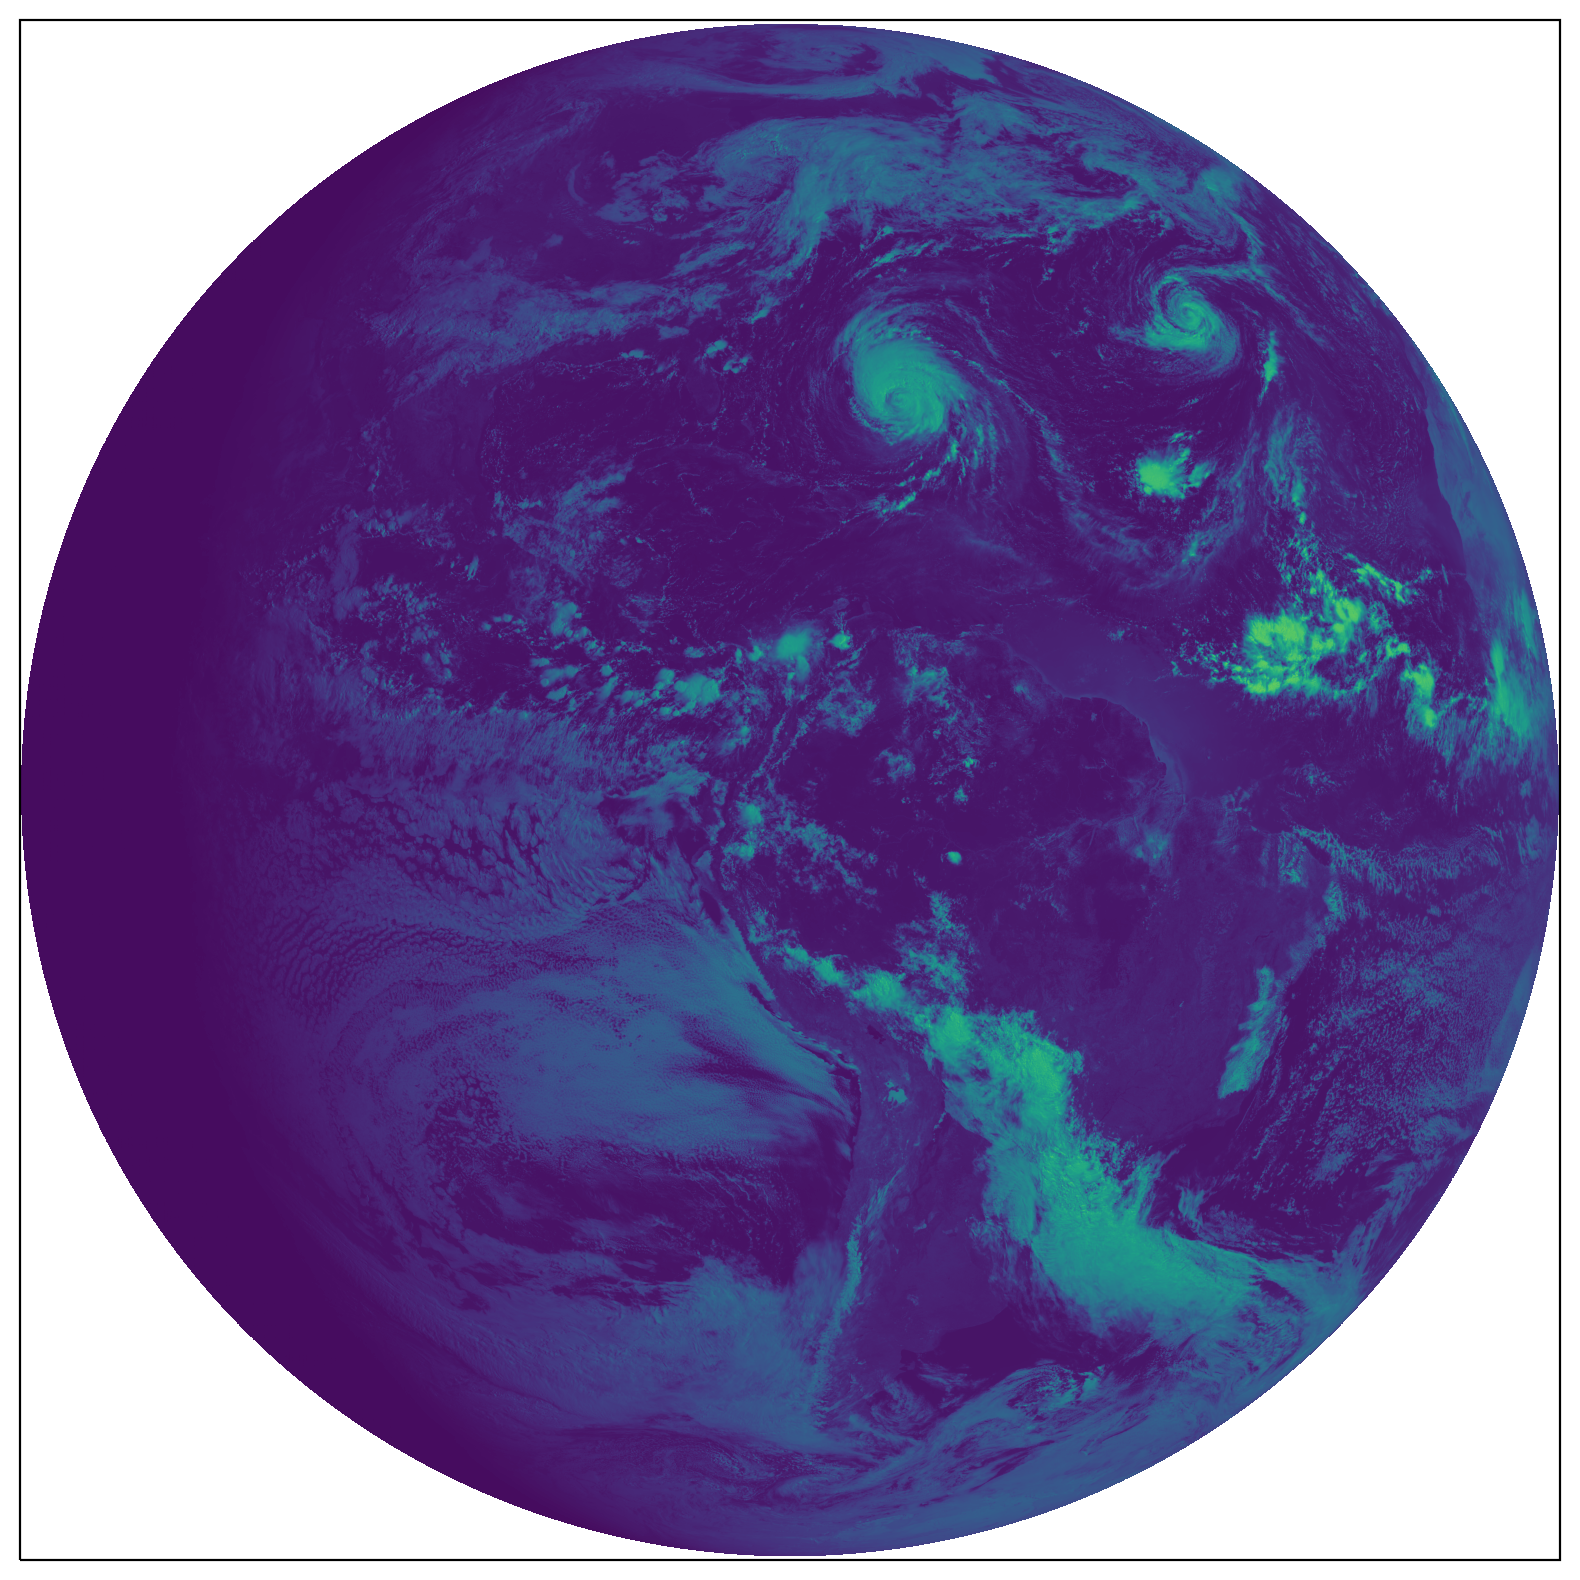

In [8]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projPC) # lo que diferencia un ax de matplotlib regular a un ax de cartopy es el argumento "projection"
img = ax.imshow(var, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper') # se plotea todos los datos disponibles
plt.show()

Para cortar la imagen a un enfóque específico y utilizar una paleta de colores diferente a la default es necesario invocar funciones de matplotlib.

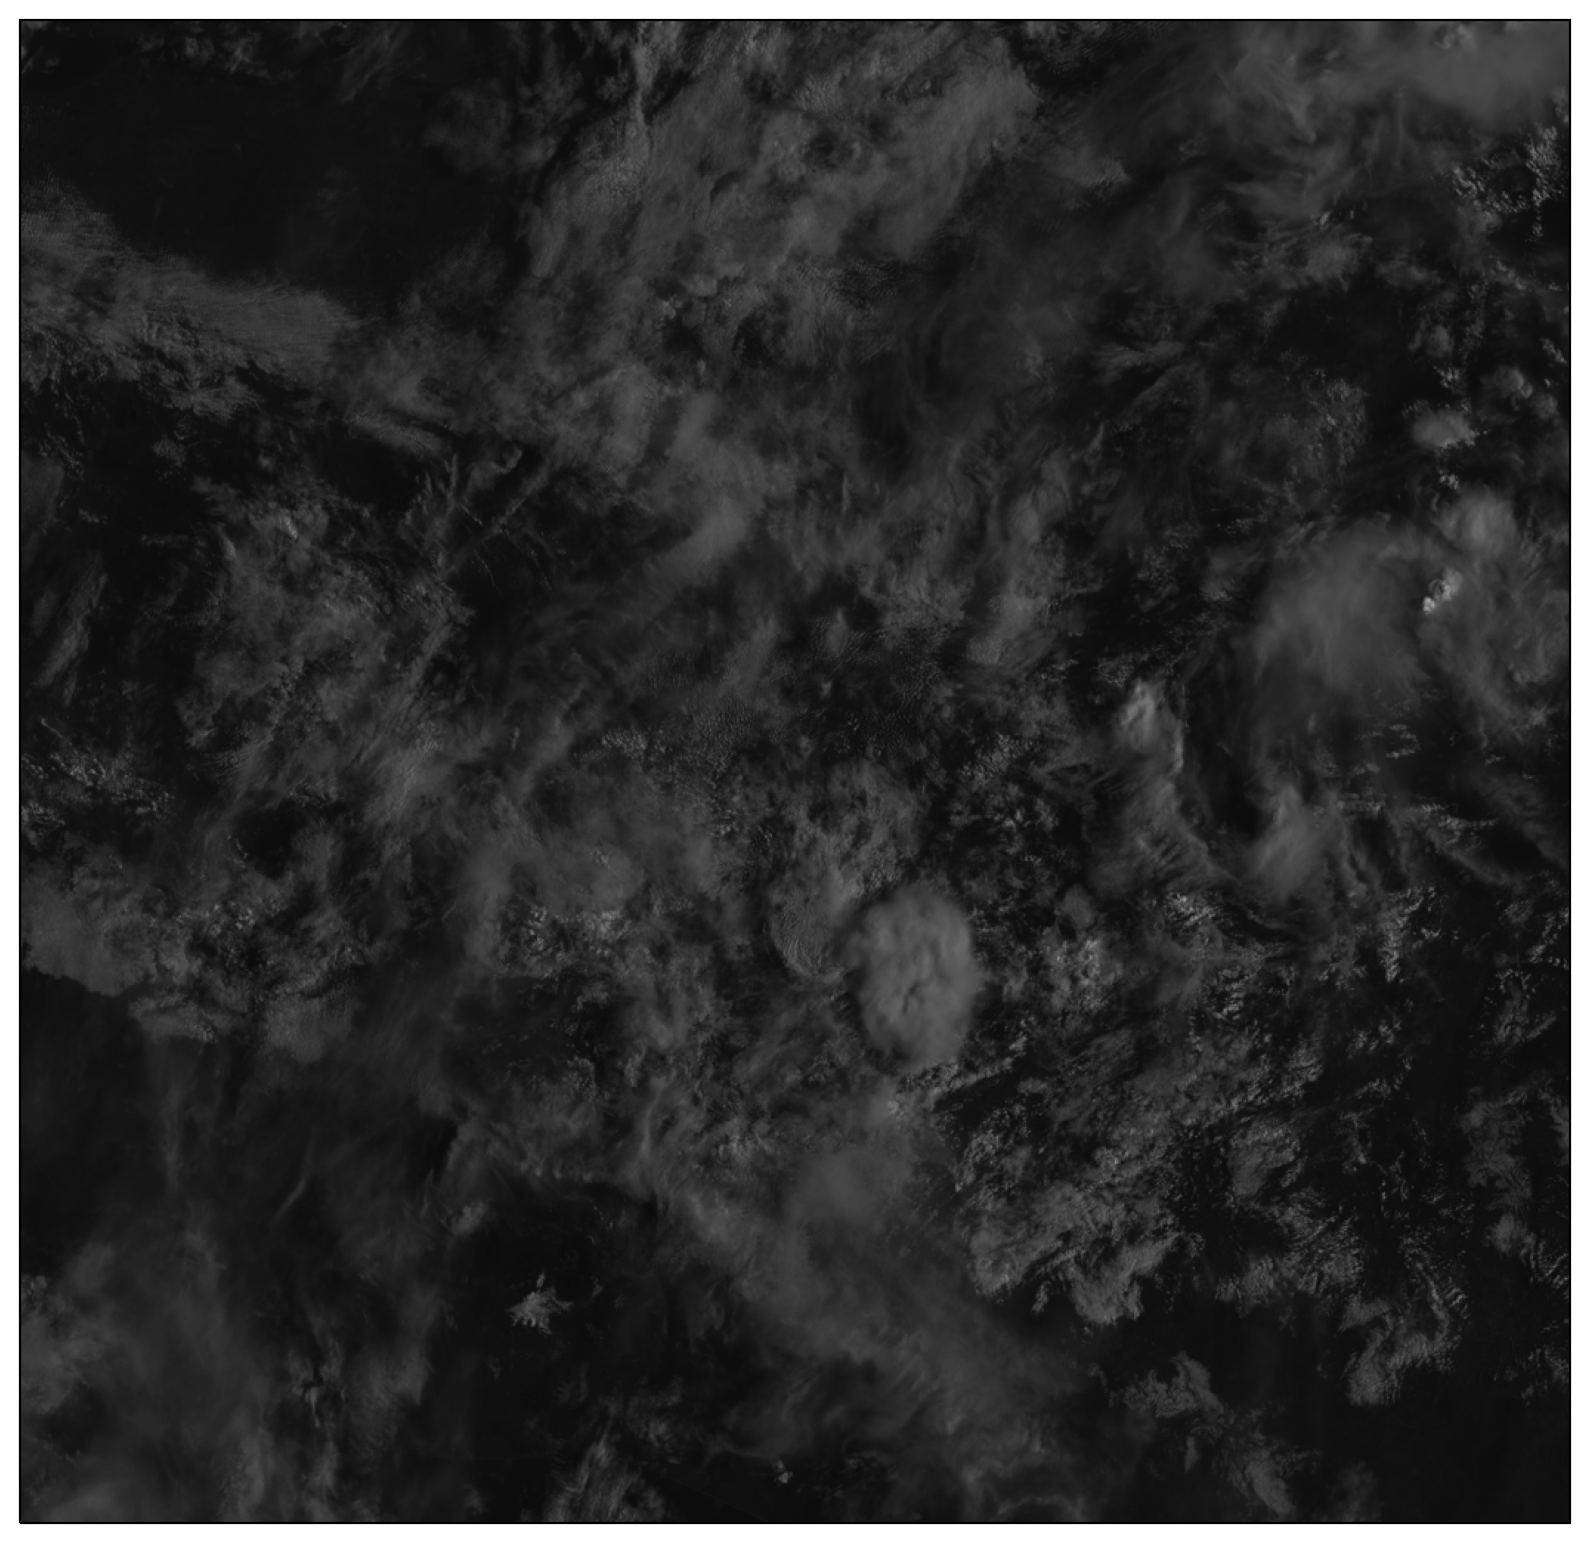

In [9]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projPC)
ax.set_extent([-92.54329965262795, -87.75789946281134, 13.722964636986774, 18.60105315166329]) # enfoque a guatemala
img = ax.imshow(var, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper', 
                     cmap=plt.get_cmap('gist_gray'))
plt.show()

Finalmente, es muy común que se requiera las fronteras, costas y bordes departamentales para hacer más legible la información de radiacia con respecto al territorio nacional. Esto es posible utilizando shapefiles y la función features de cartopy.

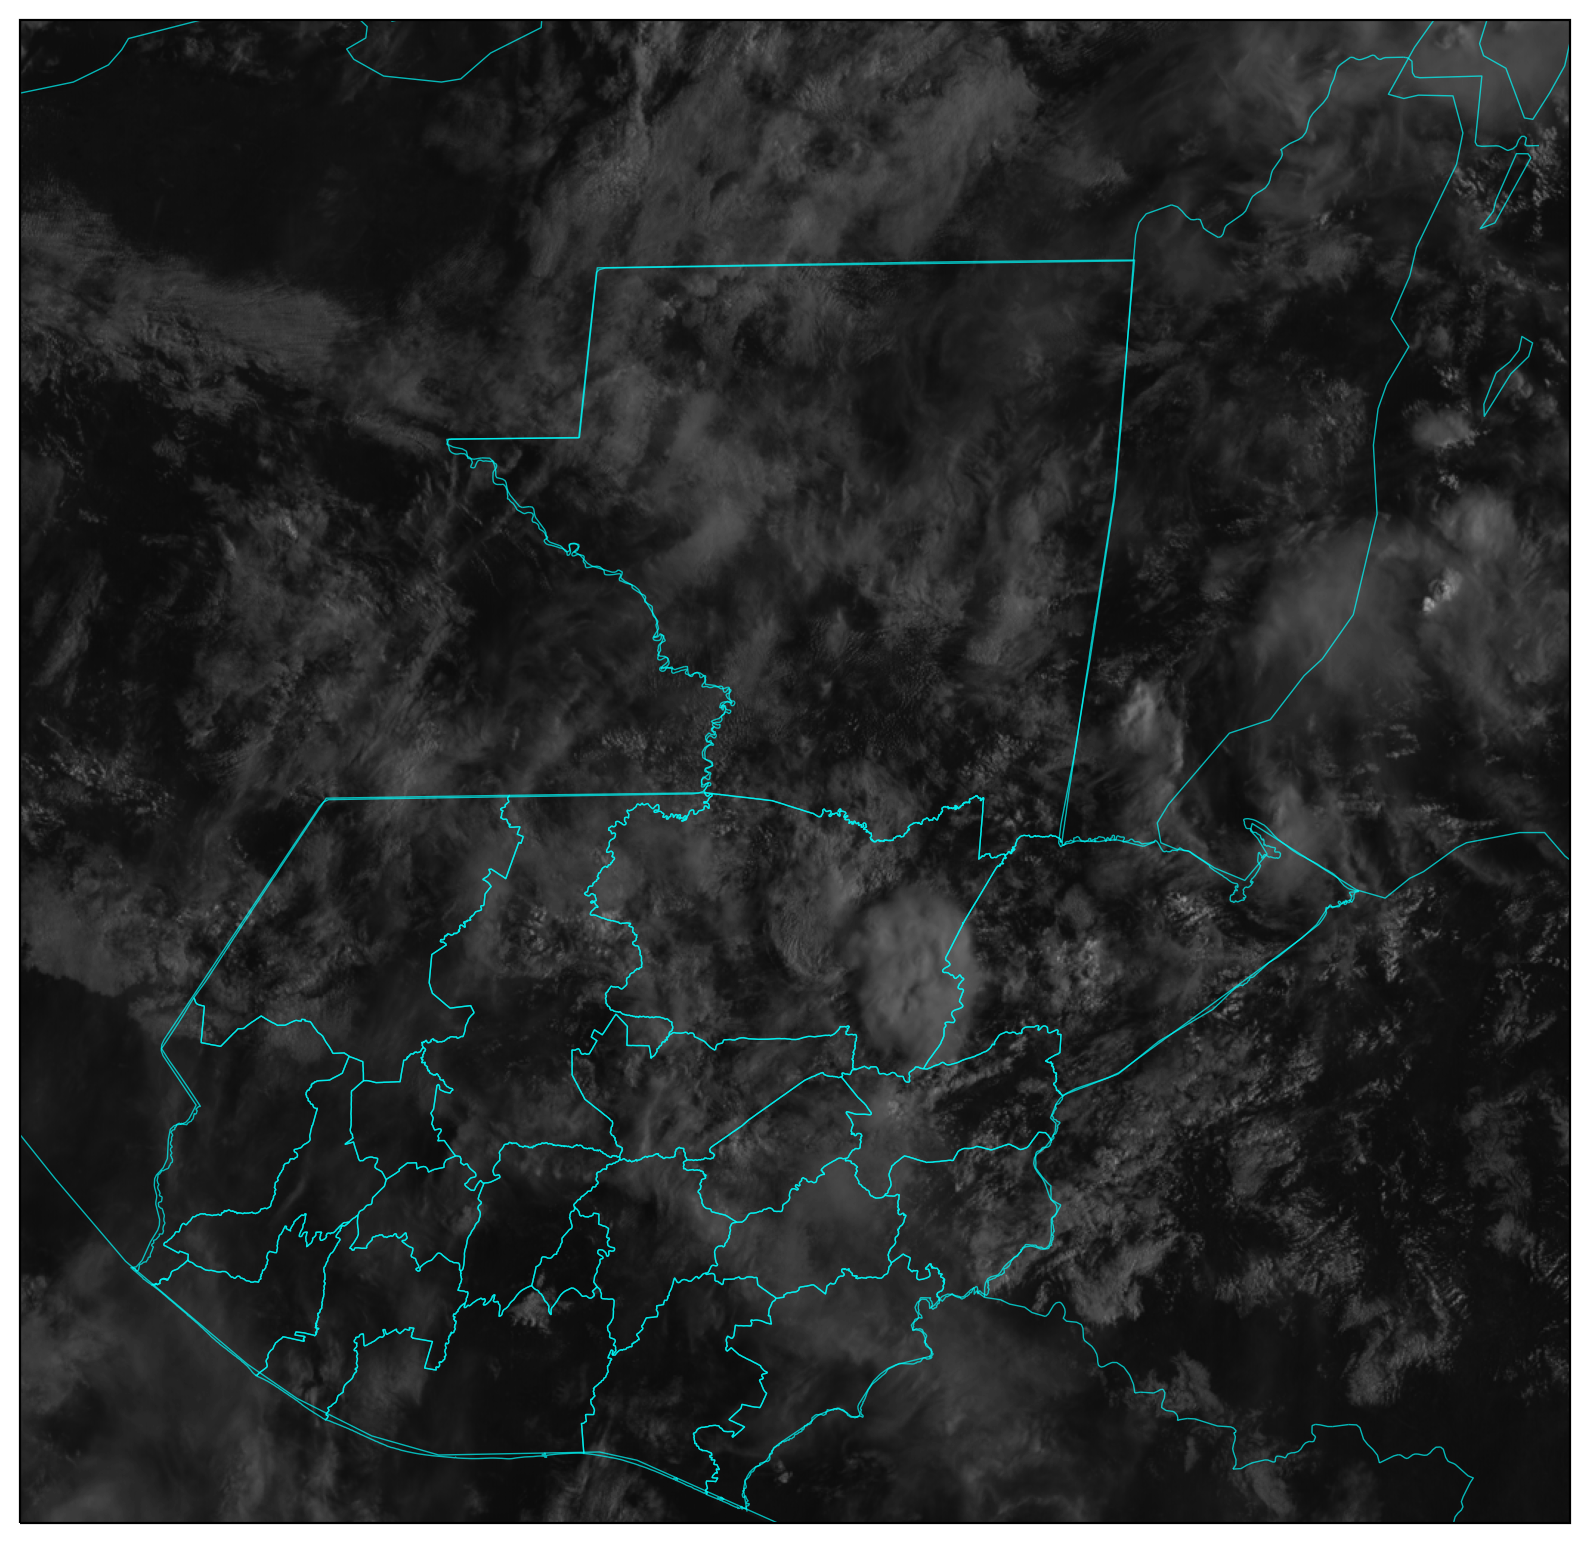

In [10]:
from cartopy import feature as cfeature
import cartopy.io.shapereader as shpreader

# Departamentos guatemala IGN
fname = './shp/departamentos_gtm_new.shp'
depa_shapes = list(shpreader.Reader(fname).geometries())

fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projPC)

ax.add_geometries(depa_shapes, crs=ccrs.PlateCarree(), #ax is already projected, so we use the closest to an identity projection when adding things on top of it
                     edgecolor='cyan', facecolor='none', alpha=0.7, zorder=3, linewidth=0.5) 

cborders = ax.add_feature(cfeature.BORDERS, edgecolor='cyan', alpha=0.7, linewidth=0.5)
ax.coastlines(resolution='50m', color='cyan', alpha=0.7, linewidth=0.5) 

ax.set_extent([-92.54329965262795, -87.75789946281134, 13.722964636986774, 18.60105315166329]) # enfoque a guatemala
img = ax.imshow(var, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper', 
                     cmap=plt.get_cmap('gist_gray'))


Para tener un producto final como el publicado en INSIVUMEH es necesario agregar meridianos y paralelos, hacer una corrección gamma, añadir texto de título y metadatos de la imágen mostrada

<Figure size 640x480 with 0 Axes>

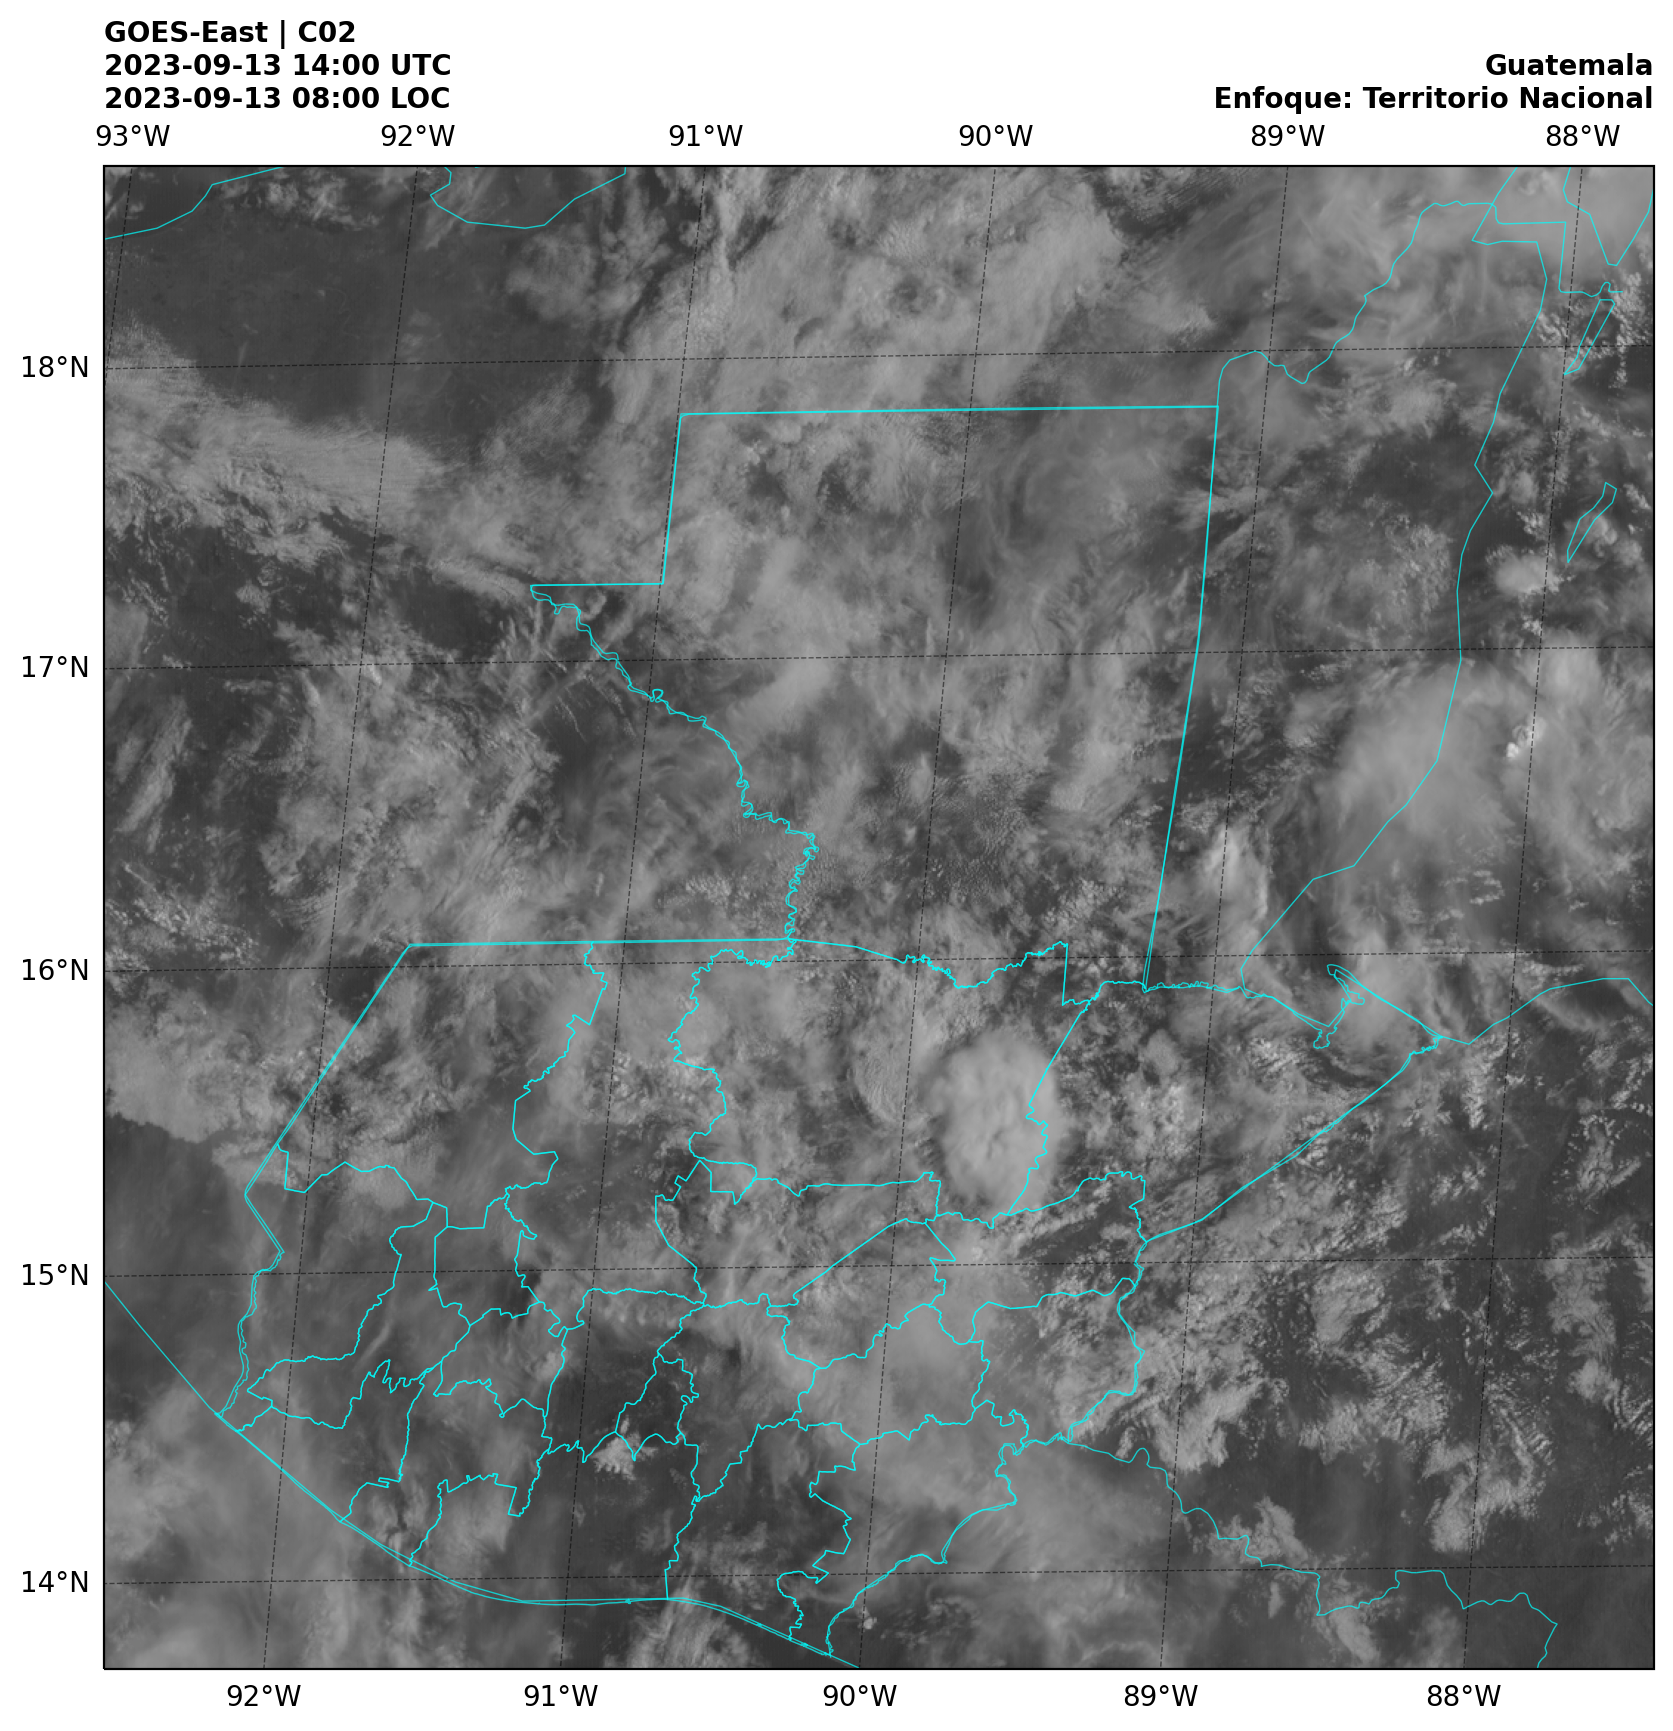

In [11]:
del fig
del ax

plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

import matplotlib.colors as colors

fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projPC)

ax.set_extent([-92.54329965262795, -87.75789946281134, 13.722964636986774, 18.60105315166329]) # enfoque a guatemala

plt.title(f"{strs['orbital_slot']} | C{ch}\n{(strs['end_time'] + dt.timedelta(minutes=1)):%Y-%m-%d %H:%M} UTC\n{(strs['end_time'] - dt.timedelta(hours=5 , minutes=59)):%Y-%m-%d %H:%M} LOC", fontweight='bold', fontsize=10,   loc='left')
plt.title(f"Guatemala\n Enfoque: Territorio Nacional", fontweight='bold', fontsize=10, loc='right')

# Departamentos guatemala IGN
fname = './shp/departamentos_gtm_new.shp'
depa_shapes = list(shpreader.Reader(fname).geometries())

ax.add_geometries(depa_shapes, crs=ccrs.PlateCarree(), #ax is already projected, so we use the closest to an identity projection when adding things on top of it
                     edgecolor='cyan', facecolor='none', alpha=0.7, zorder=3, linewidth=0.5) 

img = ax.imshow(var, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper', 
                     cmap=plt.get_cmap('gist_gray'), 
                     norm=colors.PowerNorm(gamma=0.4, vmin=0, vmax=600))

cborders = ax.add_feature(cfeature.BORDERS, edgecolor='cyan', alpha=0.7, linewidth=0.5)
ax.coastlines(resolution='50m', color='cyan', alpha=0.7, linewidth=0.5) 


gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.ylabels_right = False

plt.show()


